In [1]:
import io, requests, pynucl, warnings,sys,os,logging
warnings.filterwarnings('ignore')

from plotnine import *
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from MDAnalysis.coordinates.memory import MemoryReader
from scipy.spatial import distance
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt 
import seaborn as sns

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/Align/substitution_matrices/__init__.py:21: BiopythonExperimentalWarning: Bio.Align.substitution_matrices is an experimental module which may still undergo significant changes. In particular, the location of this module may change, and the Array class defined in this module may be moved to other existing or new modules in Biopython.
  BiopythonExperimentalWarning)


_ColormakerRegistry()

## Load data

In [2]:
sys_list=[{'s':'3lz0_ntm','ref':'3LZ0'},
          {'s':'1kx5_sym','ref':'1KX5'},
          {'s':'1kx5_ntm','ref':'1KX5'},
          {'s':'1kx5_sym_fixed','ref':'1KX5'},
          {'s':'1aoi_ntm','ref':'1AOI'}]

nconv={'3lz0_ntm':'NCP$_{145}^{tt}$',
       '1kx5_sym':'NCP$_{147}$',
       '1kx5_ntm':'NCP$_{147}^{tt}$',
       '1aoi_ntm':'NCP$_{146}^{tt}$',
       '1kx5_sym_fixed':'NCP$^{fixed}_{147}$'}
p={}
DNA={}
unw_contD={}
unw_posD={}

In [3]:
for i in sys_list:
    s=i['s']
    ref_pdb=i['ref']
    # load reference from PDB
    pdb=io.StringIO(requests.get('https://files.rcsb.org/download/%s.pdb'%(ref_pdb)).content.decode("utf-8") )
    p[ref_pdb+'_pdb']=pynucl.nuclstr(pdb,format='PDB',ref="1KX5_NRF",fullseqs='3LZ0',name=ref_pdb)
    # load trajectories
    p[s]=pynucl.nucltrj(f'../trj/{s}_for_web.pdb',f'../trj/{s}_for_web.xtc',time=(0,None,1),fullseqs=ref_pdb)

1 frames loaded for 3LZ0
157 frames loaded for 3lz0_ntm_for_web
1 frames loaded for 1KX5
154 frames loaded for 1kx5_sym_for_web
1 frames loaded for 1KX5
103 frames loaded for 1kx5_ntm_for_web
1 frames loaded for 1KX5
85 frames loaded for 1kx5_sym_fixed_for_web
1 frames loaded for 1AOI
86 frames loaded for 1aoi_ntm_for_web


## analyze DNA geometry and unwrapping

In [4]:
for i in sys_list:
    s=i['s']
    ref_pdb=i['ref']
    DNA[s]=pynucl.a_DNA(p[s],num_threads=20)
    unw_posD[s]=pynucl.a_DNAunw_pos(p[s],DNAparam=DNA[s],ref=p[ref_pdb+'_pdb'],threshold=7)
    unw_contD[s]=pynucl.a_DNAunw_cont(p[s])


BP_mindist, BP_id_closest and BP_id_shift added to df_series dataframe



BP_mindist, BP_id_closest and BP_id_shift added to df_series dataframe



BP_mindist, BP_id_closest and BP_id_shift added to df_series dataframe



BP_mindist, BP_id_closest and BP_id_shift added to df_series dataframe



BP_mindist, BP_id_closest and BP_id_shift added to df_series dataframe


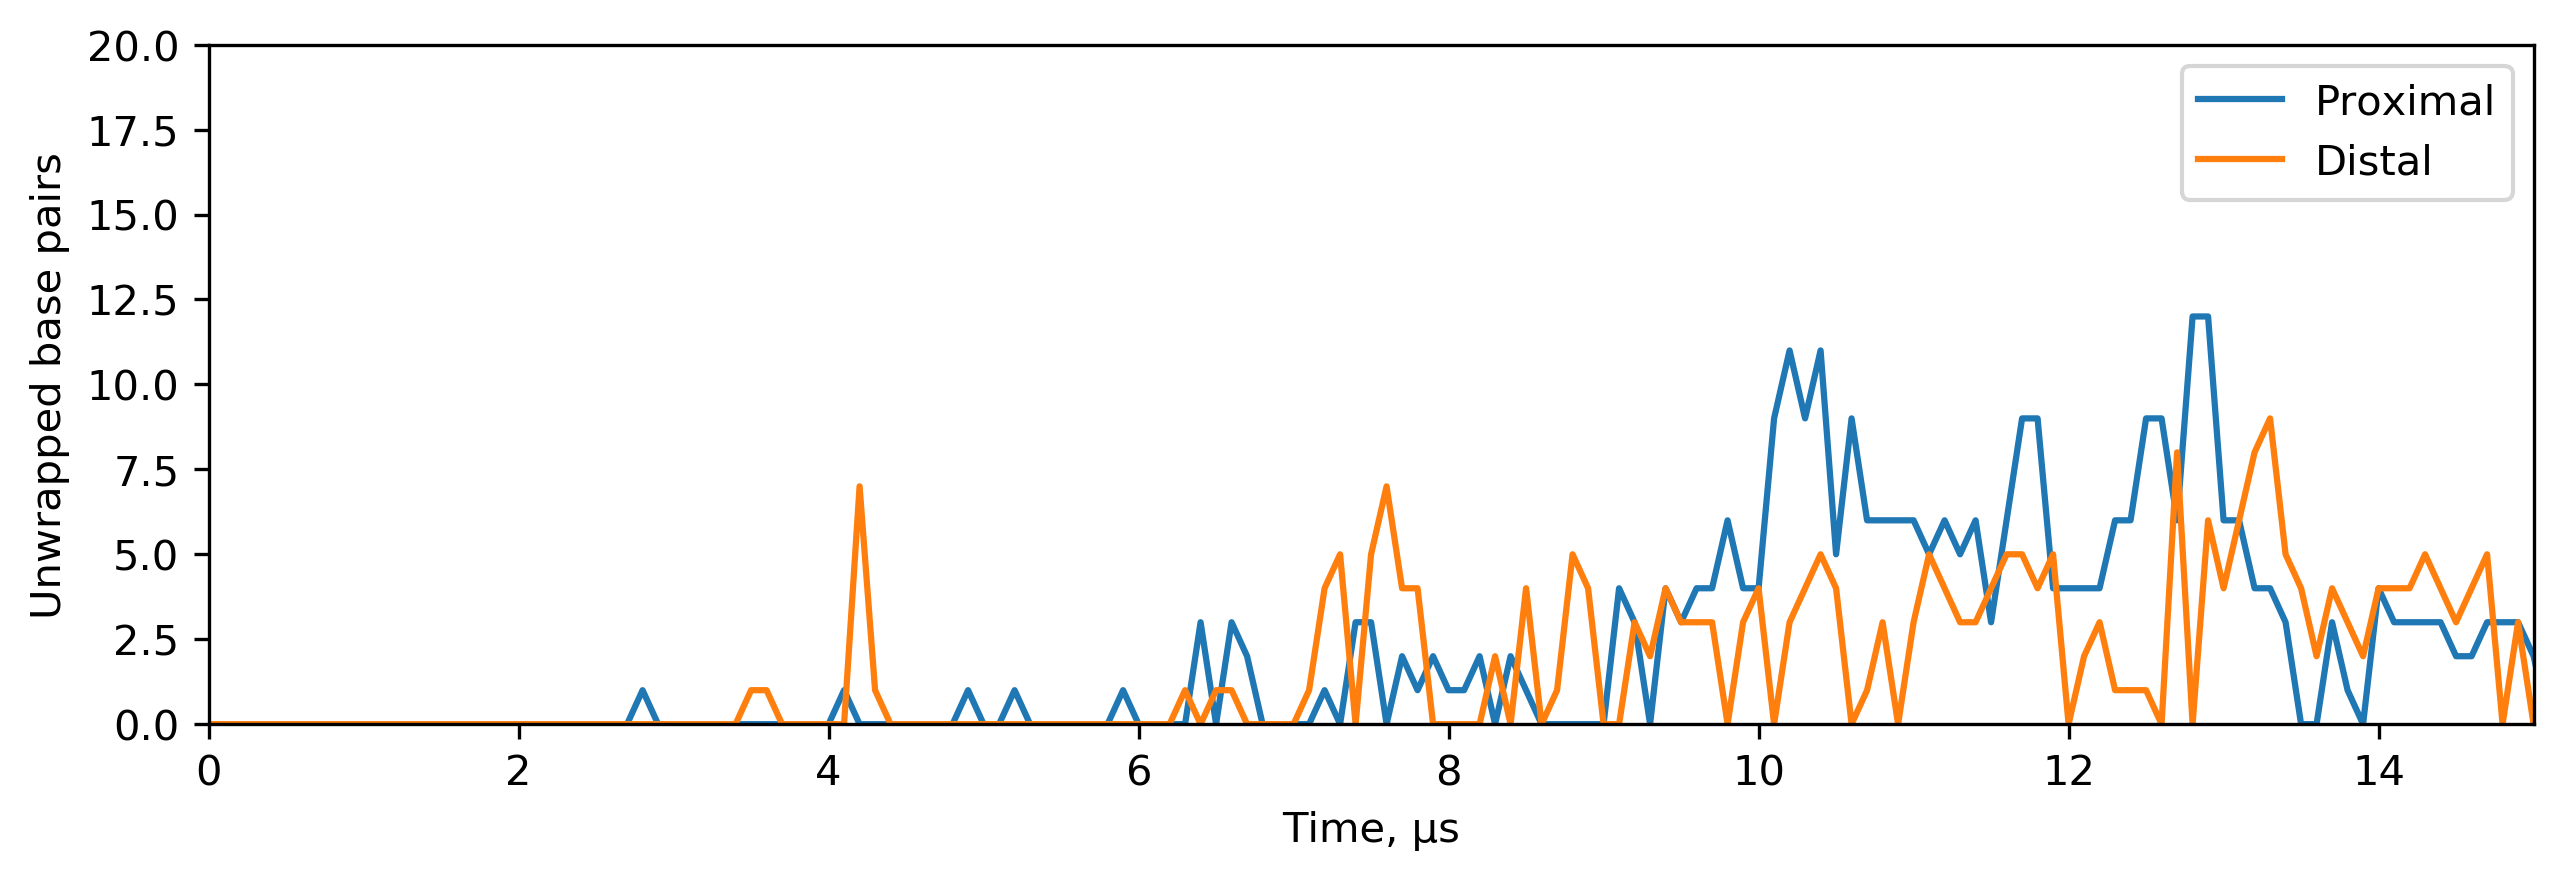

In [5]:

sysname='1kx5_sym'
temp_df=unw_posD[sysname].unw
fig,ax=plt.subplots(figsize=(10,3),dpi=300)


sns.lineplot(x=temp_df.Frame/10,y=temp_df.prox,ax=ax,markers='', linewidth=1.5,color='#1f77b4',label='Proximal')

sns.lineplot(x=temp_df.Frame/10,y=temp_df.dist,ax=ax,markers='', linewidth=1.5,color='#ff7f0e',label='Distal')
ax.set_xlabel('Time, μs')
ax.set_ylabel('Unwrapped base pairs')


plt.legend()
ax.set_ylim(0,20)
ax.set_xlim(0,15)
plt.show()

## DNA projectons

In [6]:
# compare with other structures
pdb_6ESG=io.StringIO(requests.get('https://files.rcsb.org/download/%s.pdb'%('6ESG')).content.decode("utf-8") )
p6ESG=pynucl.nuclstr(pdb_6ESG,format='PDB',ref="1KX5_NRF",fullseqs='6ESG',name='Class_2_6ESG')
DNA_6ESG=pynucl.a_DNA(p6ESG)

1 frames loaded for Class_2_6ESG


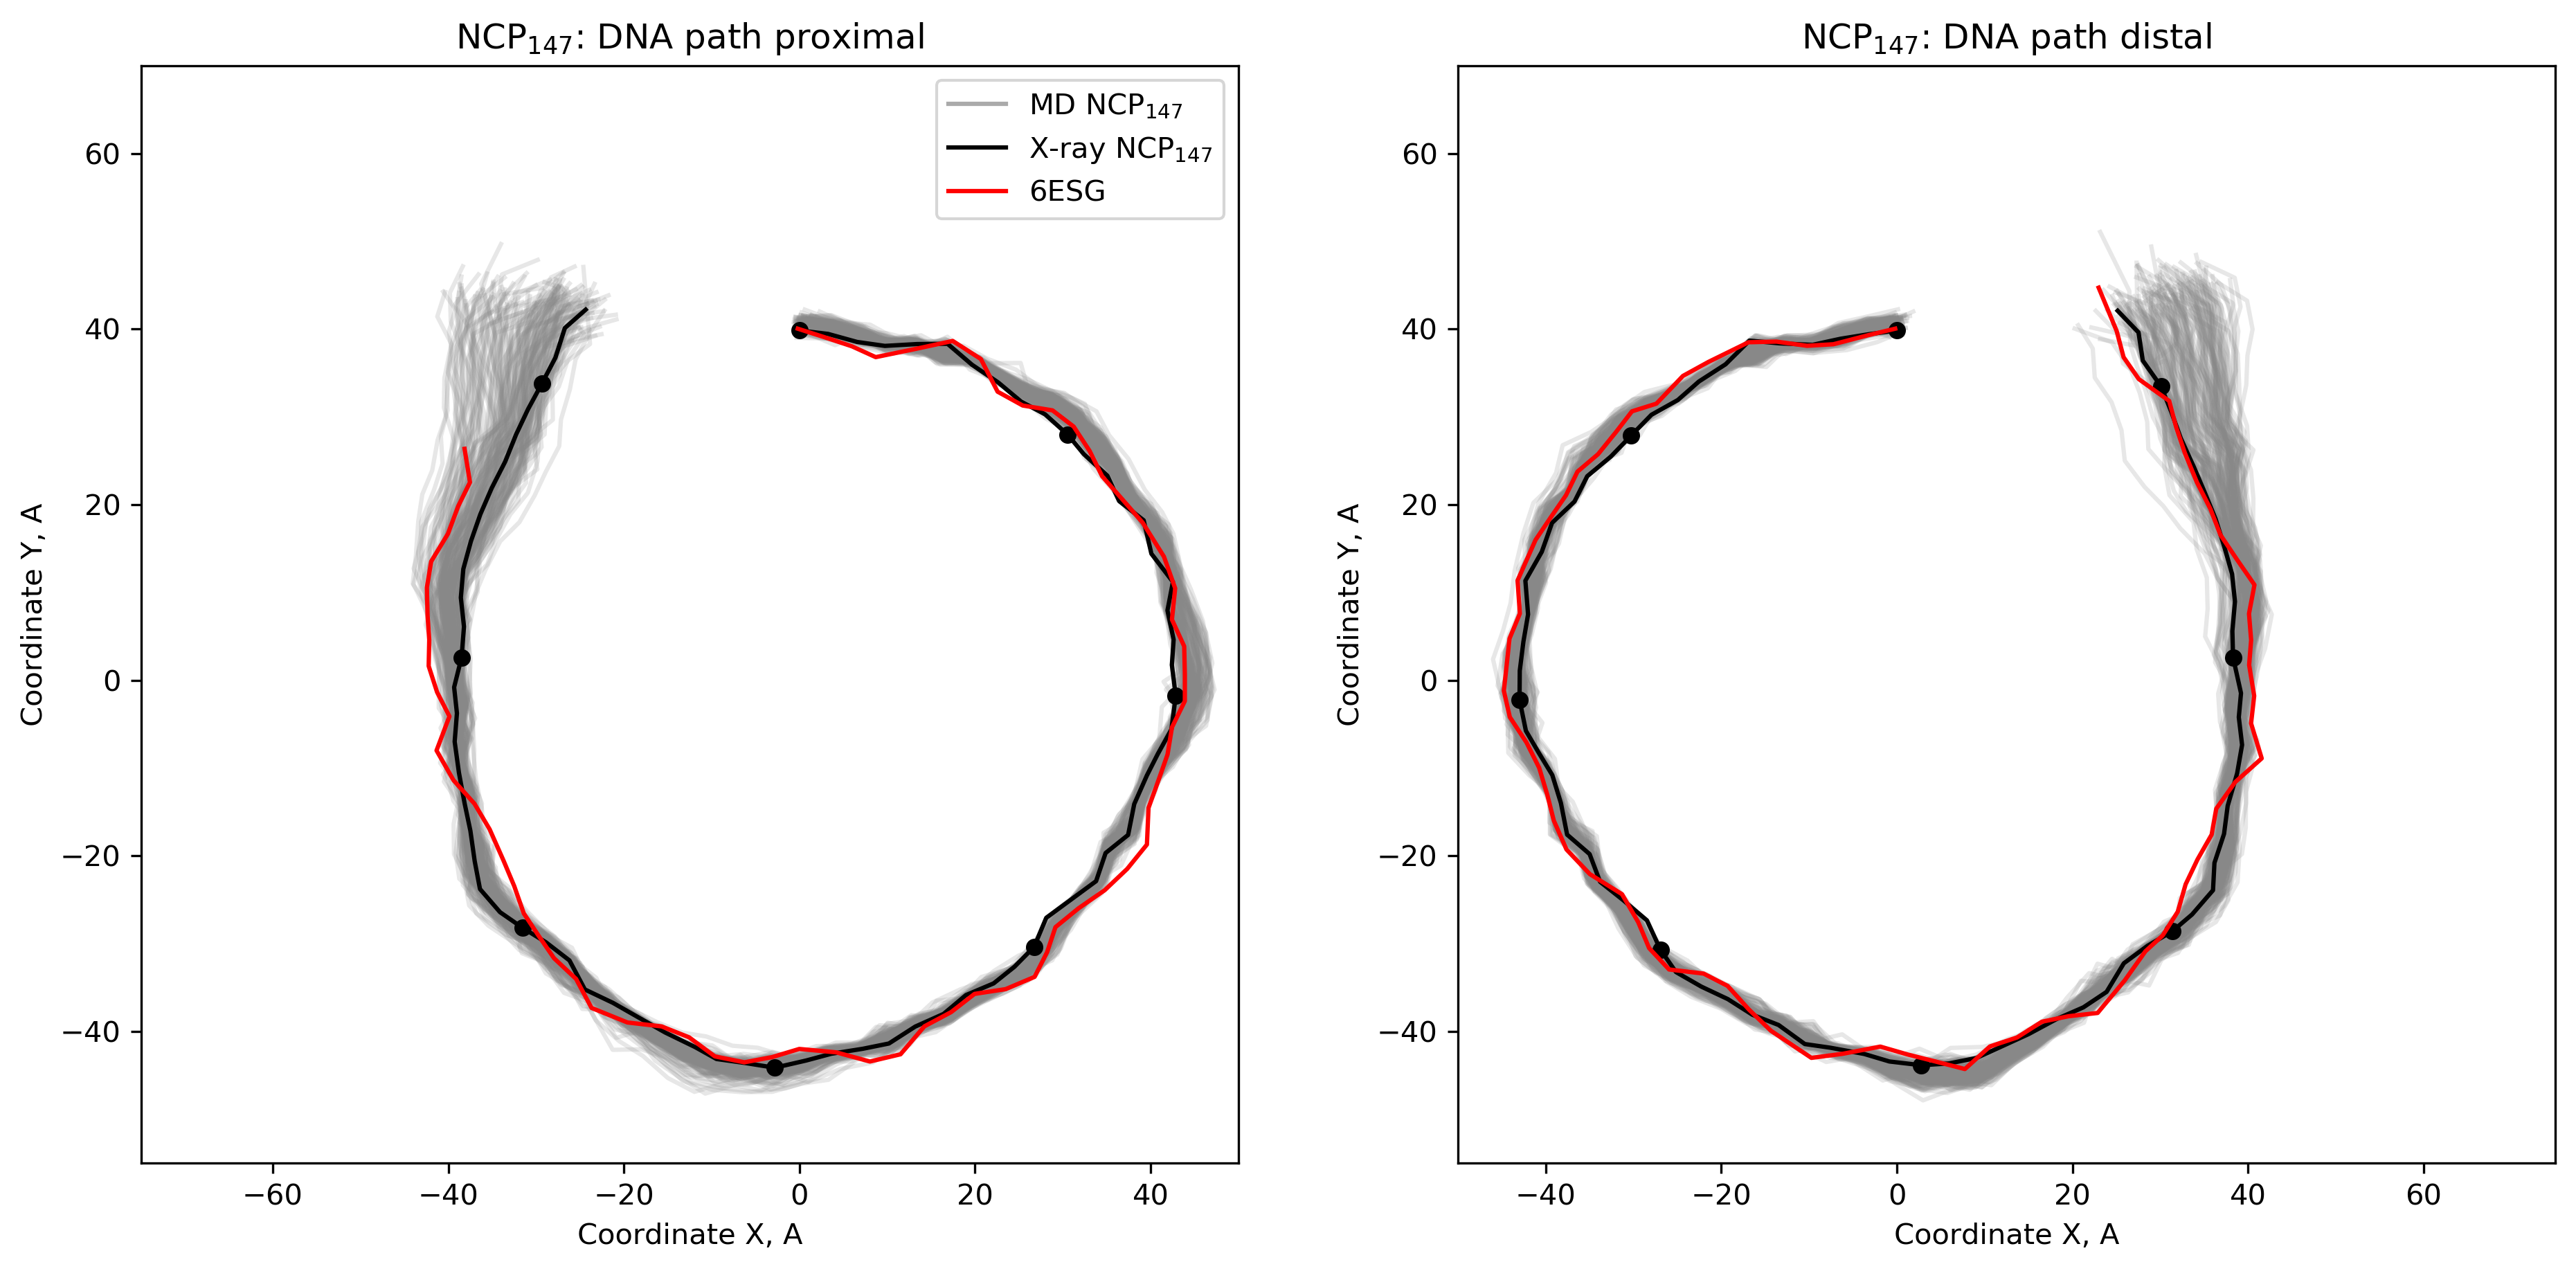

In [7]:
s='1kx5_sym' 
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7),dpi=300)
ax1=pynucl.plot_coord_fast(DNA[s].df_series[DNA[s].df_series['resid']<=0],plane='xy',
                    ref=DNA[s].df_series[(DNA[s].df_series['Frame']==0)&(DNA[s].df_series['resid']<=0)],
                    color='#888888',color_ref='black',ax=ax1,alpha=0.2)
dump=ax1.set_aspect('equal')
pdf=DNA[s].df_series[DNA[s].df_series.Frame.eq(0)]
pdf=pdf[(pdf['resid']<=0)&(pdf['resid']%10==0)]
ax1.plot(pdf.loc[:,'x'],pdf.loc[:,'y'],'.',ms=10,c='black')
l=[Line2D([0],[0],color='#AAAAAA'),Line2D([0],[0],color='black'),Line2D([0],[0],color='red')]
dump=ax1.legend(l,['MD %s'%nconv[s],'X-ray %s'%nconv[s],'6ESG'],loc=1)
ax1.set_title('%s: DNA path proximal'%nconv[s])
ax1=pynucl.plot_coord(DNA_6ESG.df[DNA_6ESG.df['resid']<=0],plane='xy',ref=None,color='red',color_ref='black',ax=ax1)

ax2=pynucl.plot_coord_fast(DNA[s].df_series[DNA[s].df_series['resid']>=0],plane='xy',
                    ref=DNA[s].df_series[(DNA[s].df_series['Frame']==0)&(DNA[s].df_series['resid']>=0)],
                    color='#888888',color_ref='black',ax=ax2,alpha=0.2)
dump=ax2.set_aspect('equal')
pdf=DNA[s].df_series[DNA[s].df_series.Frame.eq(0)]
pdf=pdf[(pdf['resid']>=0)&(pdf['resid']%10==0)]
ax2.plot(pdf.loc[:,'x'],pdf.loc[:,'y'],'.',ms=10,c='black')
l=[Line2D([0],[0],color='#AAAAAA'),Line2D([0],[0],color='black'),Line2D([0],[0],color='red')]
#dump=ax2.legend(l,['MD','X-ray','6ESG'],loc=1)
ax2.set_title('%s: DNA path distal'%nconv[s])
ax2=pynucl.plot_coord(DNA_6ESG.df[DNA_6ESG.df['resid']>=0],plane='xy',ref=None,color='red',color_ref='black',ax=ax2)


# dump=ax1.set_aspect('equal')
# l=[Line2D([0],[0],color='red'),Line2D([0],[0],color='black')]
# dump=ax1.legend(l,['6ESG','3LZ0'],
ax1.set_ylim(-55,70)
ax2.set_ylim(-55,70)
ax1.set_xlim(-75,50)
ax2.set_xlim(-50,75)
if s == '3lz0_ntm':
    ax1.set_ylim(-90,70)
    ax2.set_ylim(-90,70)
    ax2.set_xlim(-50,90)
    ax1.set_xlim(-90,50)
plt.show()

# Detecting DNA sliding or twist defects!

## By shift of positions with respect to X-ray

In [8]:
s='1kx5_sym'
DNA[s].calc_DNA_bp_closest()

BP_mindist, BP_id_closest and BP_id_shift added to df_series dataframe


In [9]:
d=DNA[s].df_series['BP_id_shift'].to_numpy()

In [10]:
dr=d.reshape(-1,p[s].DNA_top_length).T

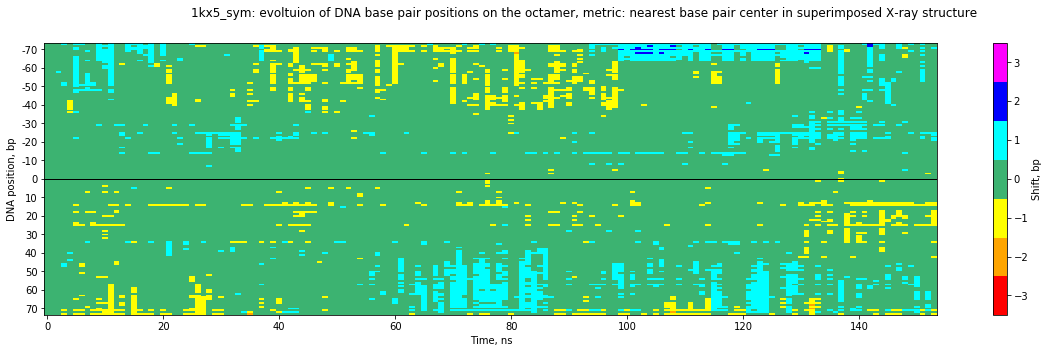

In [11]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
from matplotlib import colors
cmap = colors.ListedColormap(['red','orange','yellow', 'mediumseagreen','cyan', 'blue','magenta'])
bounds=[-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

plot1=ax.imshow(dr,cmap=cmap,norm=norm)
ax.set_aspect('auto')
ax.set_ylabel('DNA position, bp')
ax.set_xlabel('Time, ns')
ax.axhline([p[s].DNA_left_length],color='black',linewidth=1)
dump=ax.set_yticks(list(range(-(p[s].DNA_left_length-p[s].DNA_left_length%10),p[s].DNA_right_length,10))+p[s].DNA_left_length)
dum=ax.set_yticklabels(['%d'%x for x in range(-(p[s].DNA_left_length-p[s].DNA_left_length%10),p[s].DNA_right_length,10)])
fig.suptitle('%s: evoltuion of DNA base pair positions on the octamer, metric: nearest base pair center in superimposed X-ray structure'%s)
fig.colorbar(plot1, ax=ax,cmap=cmap, norm=norm,boundaries=bounds,ticks=[-3,-2,-1,0,1,2,3],label='Shift, bp')

Startnumber!=1 - is buggy currently - use at your own risk
Plotting ref


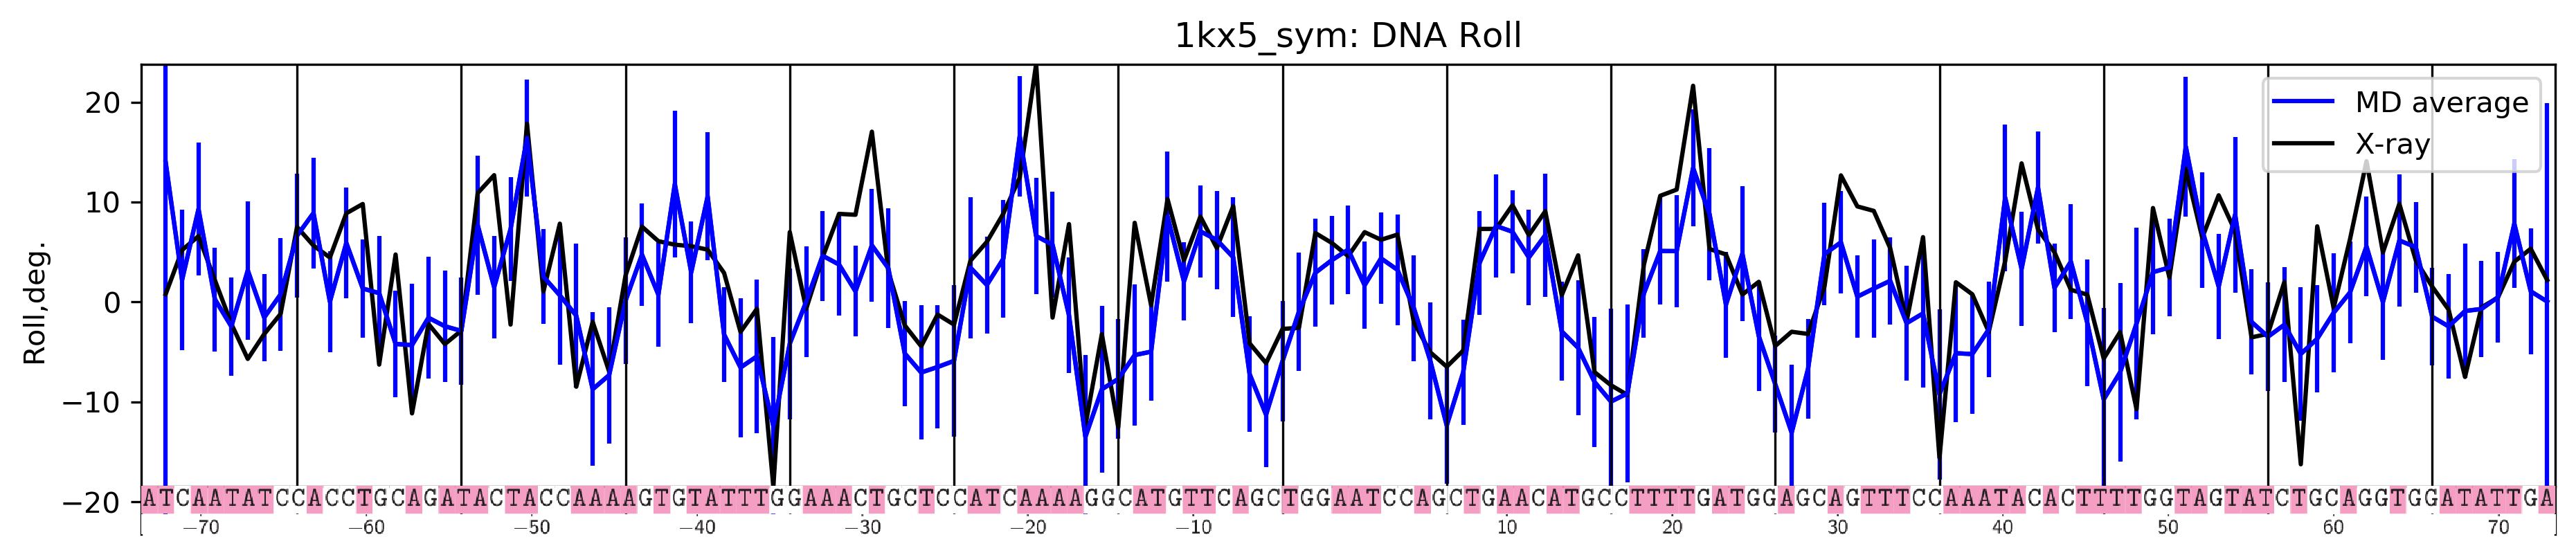

In [12]:
df=DNA[s].df.copy()
df['error']=DNA[s].df_std['Roll']
ax=pynucl.plot_line_mpl(df,p[s],column='Roll',error='error',ref=DNA[s].df_series[DNA[s].df_series['Frame']==0],startnumber=-73,funcgroups='\\funcgroup{xxx}{AT}{Black}{Lavender}{upper}{up}',color_ref='black',color='#0000FF')
# dump=ax.set_xticks([4,14,24,34,44,54,64,74,84,94,104,114,124,134])
# dump=ax.set_yticks([0,30,60,90,120,150,180])
l=[Line2D([0],[0],color='#0000FF'),Line2D([0],[0],color='black')]
dump=ax.legend(l,['MD average','X-ray'],loc=1)
dump=ax.set_title('%s: DNA Roll'%s)
dump=ax.set_ylabel('Roll,deg.')
ax.set_axisbelow(False)
# ax.errorbar(DNA[s].df['resid']+74,DNA[s].df_)
# ax.grid(axis='x', color='0.0',zorder=3)
# ax.hlines([90],[0],[150],color=['#AAAAAAAA'],linestyles=['--'])

In [13]:
DNArTw={}
DNArTw[s]=pynucl.a_DNArtw(p[s])

Startnumber!=1 - is buggy currently - use at your own risk
Plotting ref


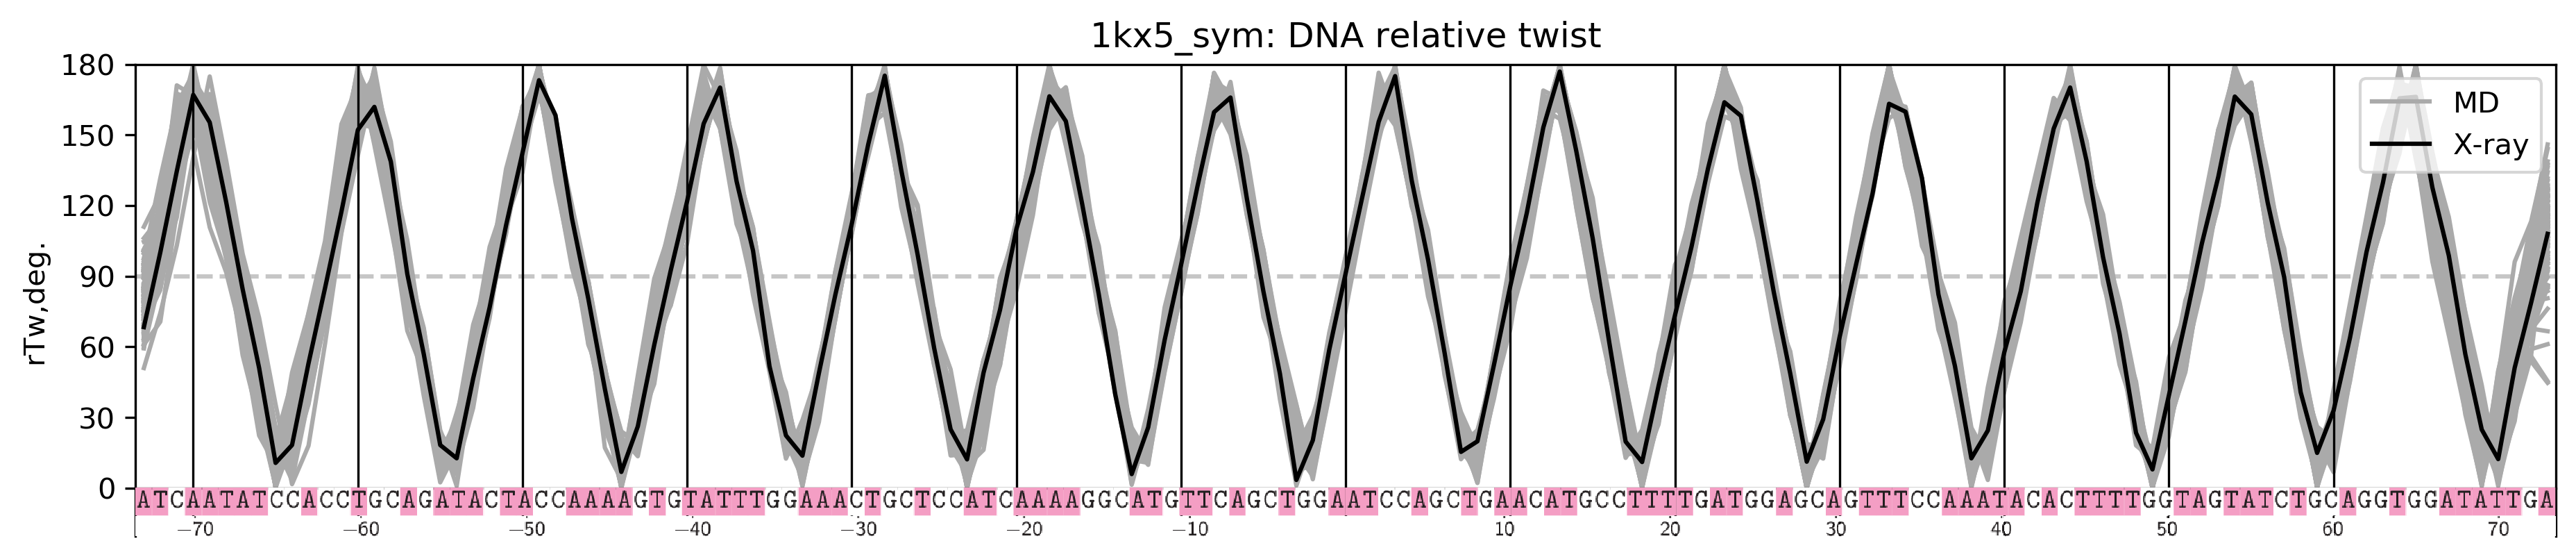

In [14]:
ax=pynucl.plot_line_mpl(DNArTw[s].df_series,p[s],column='rTw',ref=DNArTw[s].df_series[DNArTw[s].df_series['Frame']==0],startnumber=-73,funcgroups='\\funcgroup{xxx}{AT}{Black}{Lavender}{upper}{up}',color_ref='black',color='#AAAAAA')
dump=ax.set_xticks([4,14,24,34,44,54,64,74,84,94,104,114,124,134])
dump=ax.set_yticks([0,30,60,90,120,150,180])
l=[Line2D([0],[0],color='#AAAAAA'),Line2D([0],[0],color='black')]
dump=ax.legend(l,['MD','X-ray'],loc=1)
dump=ax.set_title('%s: DNA relative twist'%s)
dump=ax.set_ylabel('rTw,deg.')
ax.set_axisbelow(False)
ax.grid(axis='x', color='0.0',zorder=3)
ax.hlines([90],[0],[150],color=['#AAAAAAAA'],linestyles=['--'])

## Histone folds projections

In [ ]:
cD={}
for i in sys_list:
    s=i['s']
    ref_pdb=i['ref']
    c={}
    c['alpha1']={}
    c['alpha2']={}
    c['alpha3']={}
    for alpha in ['alpha1','alpha2','alpha3']:
        for hist in ['H3','H4','H2A','H2B']:
            c[alpha][hist]=pynucl.a_geom(p[s],'coord',('%s and %s and name CA'%(hist,alpha)),rmsd_superposition=False,sel_split='atom')
    cD[s]=c



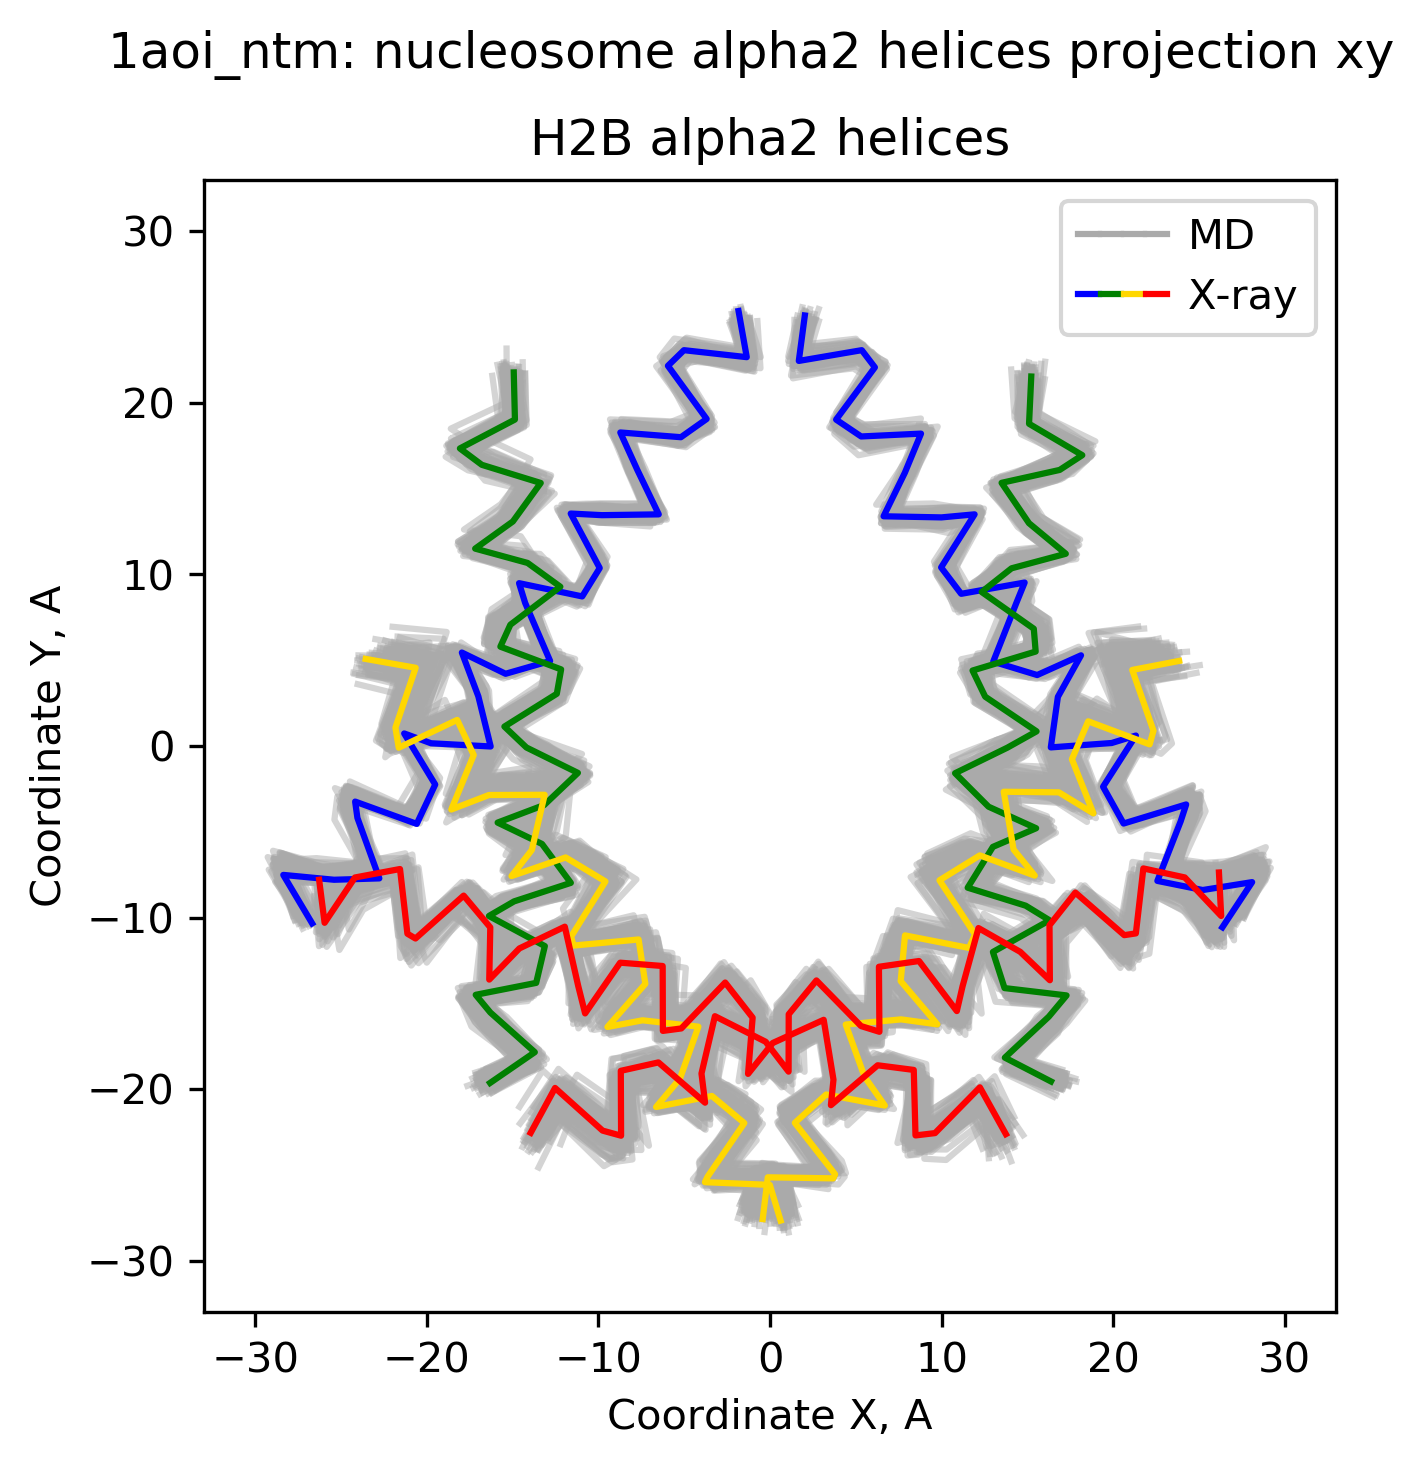

In [16]:
import matplotlib.pyplot as plt 
c=cD[s]
color_ref={'H3':'blue','H4':'green','H2A':'gold','H2B':'red'}

for alpha in ['alpha2']:
    
    for proj in ['xy']:
        fig,ax=plt.subplots(1,1,figsize=(5,5),dpi=300)
        for hist in ['H3','H4','H2A','H2B']:
            ax=pynucl.plot_coord_fast(c[alpha][hist].df_series,
                                      plane=proj,
                                      ref=c[alpha][hist].df_series[c[alpha][hist].df_series['Frame']==0],
                                      color='#AAAAAA',color_ref=color_ref[hist],ax=ax,alpha=0.5)
            dump=ax.set_aspect('equal')
            line= Line2D([0],[0],color='#AAAAAA')
            pa1 = Line2D([0],[0],color='blue')
            pa2 = Line2D([0],[0],color='green')
            pa3 = Line2D([0],[0],color='gold')
            pa4 = Line2D([0],[0],color='red')


            dump=ax.legend(handles=[line, pa1, line, pa2,line, pa3, line, pa4],
                      labels=['','', '', '', '', '', 'MD', 'X-ray'],
                      ncol=4, handletextpad=0.5, handlelength=0.5, columnspacing=-0.45)

            ax.set_title('%s %s helices'%(hist,alpha))
            ax.set_xlim(-33,33)
            ax.set_ylim(-33,33)
        fig.suptitle('%s: nucleosome %s helices projection %s'%(s,alpha,proj))

## Plotting Contact profiles along the histone sequence
- The idea here is to get stable atom-atom contacts and plot for every residue the average number between two symmetry related chains.
- Also it will be good to plot for 1 mic sec and all in a dodged style.


In [17]:
#specify, what we want:
s='1kx5_sym'
maxtime=1000 #in frames
threshold=0.9 # threshold for stable contacts 0.9 - means present in 90% of frames

In [18]:
c_dna_allD={}


In [ ]:
for i in sys_list:
    s=i['s']
    ref_pdb=i['ref']
    c_dna_allD[s]=pynucl.a_contacts(p[s],'(segid I or segid J) and (not (name H* 1* 2* 3*))','protein and (not (name H* 1* 2* 3*))',time=(0,None,1))
    dump=c_dna_allD[s].get_df_series()
#     c_hist_allD[s]=pynucl.a_contacts(p[s],'protein and (not (name H* 1* 2* 3*))','(segid I or segid J) and (not (name H* 1* 2* 3*))',time=(0,None,1))




In [20]:
s='1kx5_sym'
dfs=c_dna_allD[s].contdf_series[c_dna_allD[s].contdf_series['Frame']<maxtime].copy()      
df_avr=dfs.groupby(['A_atom_ix','A_atom_name','A_resname',
                                                    'A_segid','A_resid','B_atom_ix',
                                                    'B_atom_name','B_resname','B_segid','B_resid']).size().reset_index()
df_avr.columns=['A_atom_ix','A_atom_name','A_resname',
                                 'A_segid','A_resid','B_atom_ix',
                                 'B_atom_name','B_resname','B_segid'
                                 ,'B_resid','num_int']
maxframe=dfs['Frame'].max()
df_avr['num_int']=df_avr['num_int']/float(maxframe+1)
df=df_avr
df2=df[df['num_int']>threshold]
df2['num_int']=1
#Do averaging
df2=df2.replace({'E':'A','F':'B','G':'C','H':'D'})


df2=df2.groupby(['B_resname','B_segid','B_resid']).size().reset_index()
df2.columns=['resname','segid','resid','num_cont']
df2['num_cont']=df2['num_cont']/2
dm=df2

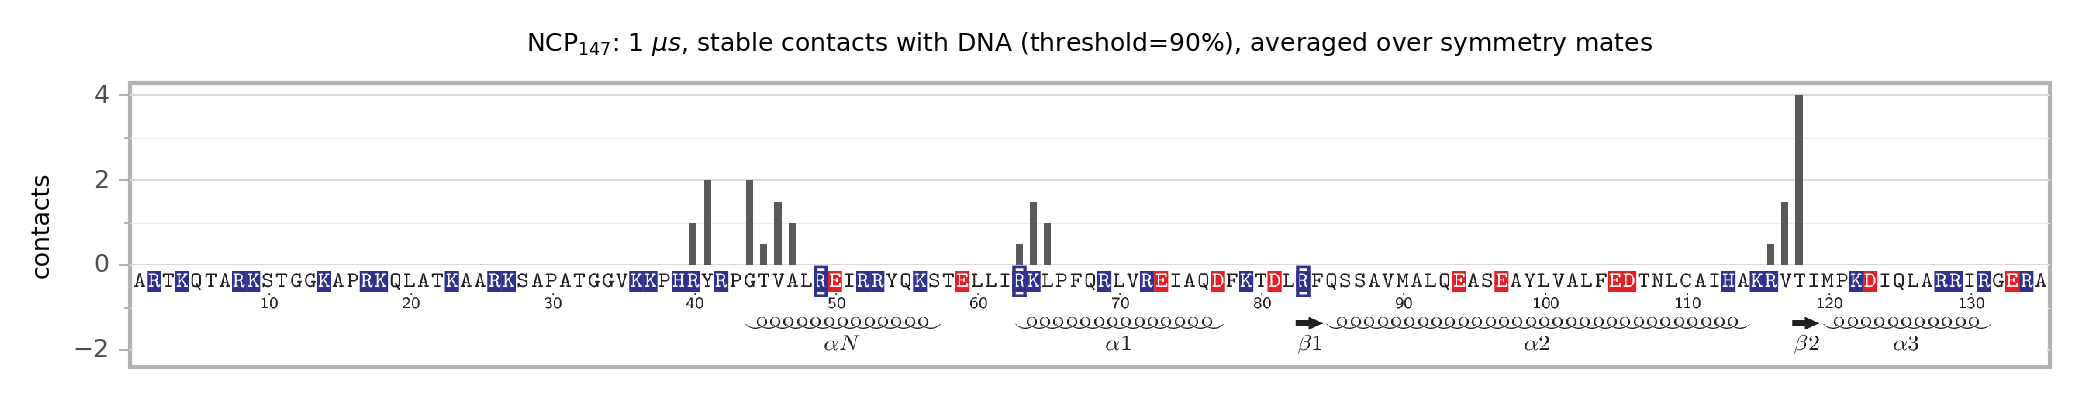

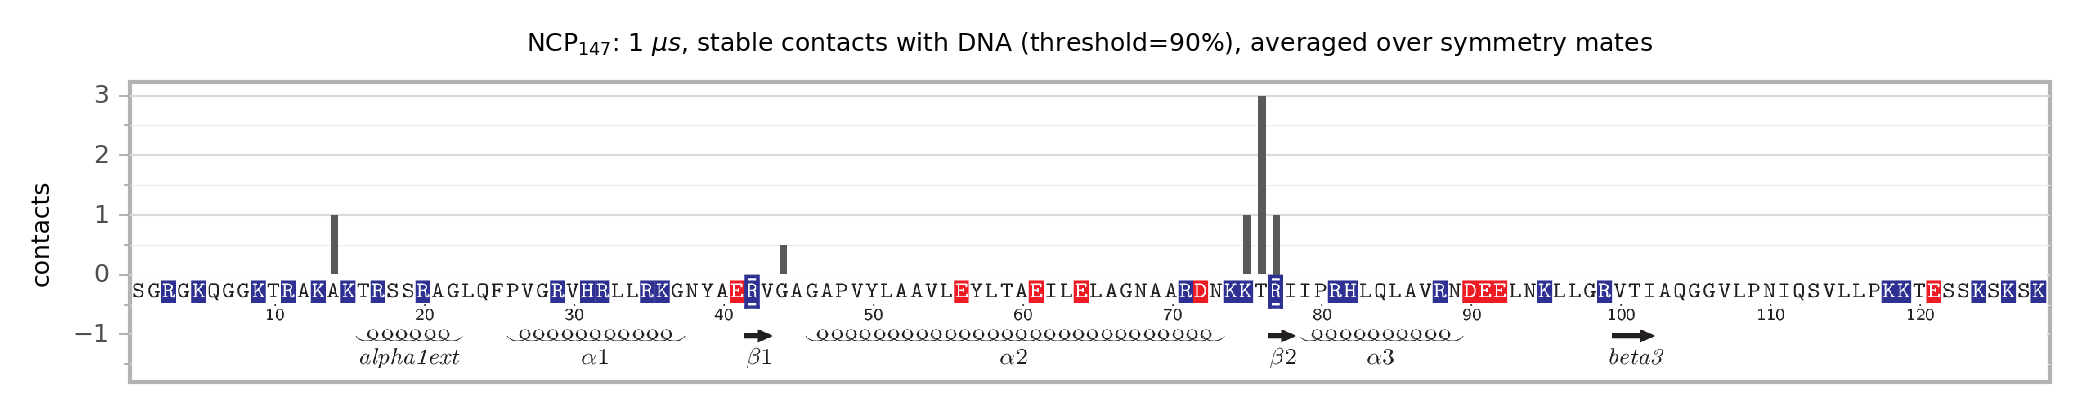

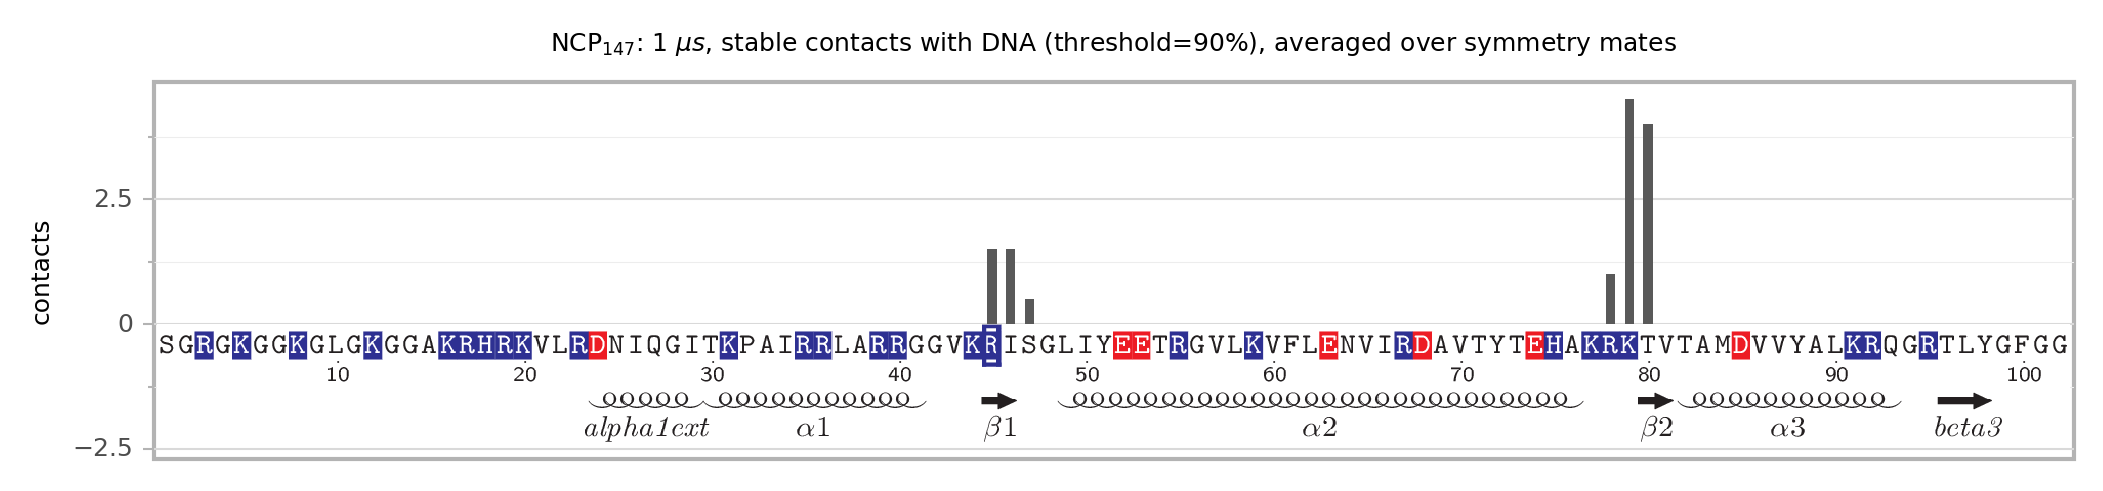

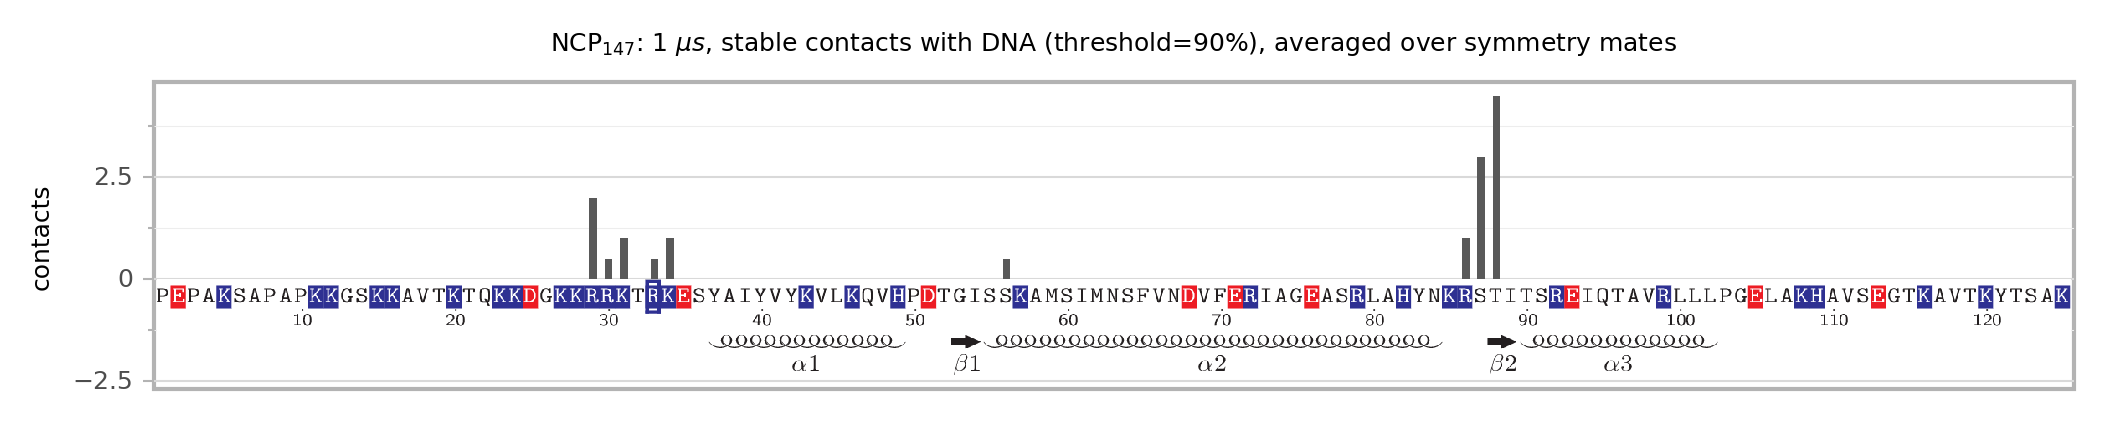

[<ggplot: (-9223363257885798719)>,
 <ggplot: (-9223363257885900782)>,
 <ggplot: (-9223363257881741466)>,
 <ggplot: (8778973318478)>]

In [21]:
title='%s: %d $\mu s$, stable contacts with DNA (threshold=%d%%), averaged over symmetry mates'%(nconv[s],maxtime/1000,threshold*100)

dm['contacts']=dm['num_cont']
fill_params={'values':['#0000FF','#9999FF','#00FF00','#99FF99','#FFD700','#FFD799','#FF0000','#FF9999'],'name':'Histone'}

pynucl.plot_bar(dm,p[s],column='contacts',factor=None,transparent=False,fill_params=fill_params,title=title,dpi=300,debug=False,ymin=0,feature_types=['helix','-->','frameblock'],reverse_seq=False)